## Import event log

- Describe and visualize the general underlying process flow. Make sure you provide a reasonable level of abstraction. You may use BPMN / Petri Nets.

- How long do the different process instances take? Are there any notable patterns?
- Are there any bottlenecks? If yes, where? If yes, can you think of any reasons?
    -> Prozessdauer vizualisieren auf Petri Net(?)
 
- Are there any patterns that would suggest non-conformance?
    -> Conformance [check from PM4PY](https://pm4py.fit.fraunhofer.de/documentation#conformance)

--- 
- How many applications get rejected? Can you find any reasons?

- Can you find any unexpected behavior, e.g. missing permits?

- Are there notable differences between international and domestic declarations?

- What is missing to provide more detailed insights into the processes?

- Reflect on where supervised / unsupervised machine learning techniques could help to obtain further insights.
 
- Can you think of useful KPIs for the processes?

- Make specific recommendations for improving the processes


In [97]:
import pm4py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [244]:
domestic_path = 'data/DomesticDeclarations.xes'
international_path = 'data/InternationalDeclarations.xes'

log= pm4py.read_xes(domestic_path);

parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

## Statistical Analysis of Event Data

In [99]:
log.head(10)

,id,org:resource,concept:name,time:timestamp,org:role,case:id,case:concept:name,case:BudgetNumber,case:DeclarationNumber,case:Amount
0,st_step 86794_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 08:49:50+00:00,EMPLOYEE,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
1,st_step 86793_0,STAFF MEMBER,Declaration FINAL_APPROVED by SUPERVISOR,2017-01-09 10:27:48+00:00,SUPERVISOR,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
2,dd_declaration 86791_19,SYSTEM,Request Payment,2017-01-10 08:34:44+00:00,UNDEFINED,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
3,dd_declaration 86791_20,SYSTEM,Payment Handled,2017-01-12 16:31:22+00:00,UNDEFINED,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
4,st_step 86798_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 09:26:14+00:00,EMPLOYEE,declaration 86795,declaration 86795,budget 86566,declaration number 86796,182.464172
5,st_step 86799_0,STAFF MEMBER,Declaration APPROVED by PRE_APPROVER,2017-02-22 09:29:21+00:00,PRE_APPROVER,declaration 86795,declaration 86795,budget 86566,declaration number 86796,182.464172
6,st_step 86797_0,STAFF MEMBER,Declaration FINAL_APPROVED by SUPERVISOR,2017-02-23 07:14:45+00:00,SUPERVISOR,declaration 86795,declaration 86795,budget 86566,declaration number 86796,182.464172
7,dd_declaration 86795_19,SYSTEM,Request Payment,2017-03-06 13:07:25+00:00,UNDEFINED,declaration 86795,declaration 86795,budget 86566,declaration number 86796,182.464172
8,dd_declaration 86795_20,SYSTEM,Payment Handled,2017-03-13 16:30:59+00:00,UNDEFINED,declaration 86795,declaration 86795,budget 86566,declaration number 86796,182.464172
9,st_step 86804_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 10:13:33+00:00,EMPLOYEE,declaration 86800,declaration 86800,budget 86566,declaration number 86801,320.646137


In [221]:
# show rows where case:id not equal case:concept:name
log[log['case:id'] != log['case:concept:name']]

,id,org:resource,concept:name,time:timestamp,org:role,case:id,case:concept:name,case:BudgetNumber,case:DeclarationNumber,case:Amount


It looks like case_id and case_concept_name columns are the same.

In [222]:
# to improve readability we trim the word 'Declaration' out of concept:name column, if it exists
log['concept:name'] = log['concept:name'].str.replace('Declaration ', '')

In [186]:
# pick random case
case_ids = log['case:id'].unique()
random_case = log[log['case:id'] == np.random.choice(case_ids)]
random_case = random_case.sort_values(by='time:timestamp')
random_case

,id,org:resource,concept:name,time:timestamp,org:role,case:id,case:concept:name,case:BudgetNumber,case:DeclarationNumber,case:Amount
3878,st_step 91491_0,STAFF MEMBER,SUBMITTED by EMPLOYEE,2017-06-01 07:13:18+00:00,EMPLOYEE,declaration 91489,declaration 91489,budget 86566,declaration number 91490,17.998285
3879,st_step 91492_0,STAFF MEMBER,FINAL_APPROVED by SUPERVISOR,2017-06-01 07:34:23+00:00,SUPERVISOR,declaration 91489,declaration 91489,budget 86566,declaration number 91490,17.998285
3880,dd_declaration 91489_19,SYSTEM,Request Payment,2017-06-01 12:59:23+00:00,UNDEFINED,declaration 91489,declaration 91489,budget 86566,declaration number 91490,17.998285
3881,dd_declaration 91489_20,SYSTEM,Payment Handled,2017-06-08 15:30:52+00:00,UNDEFINED,declaration 91489,declaration 91489,budget 86566,declaration number 91490,17.998285


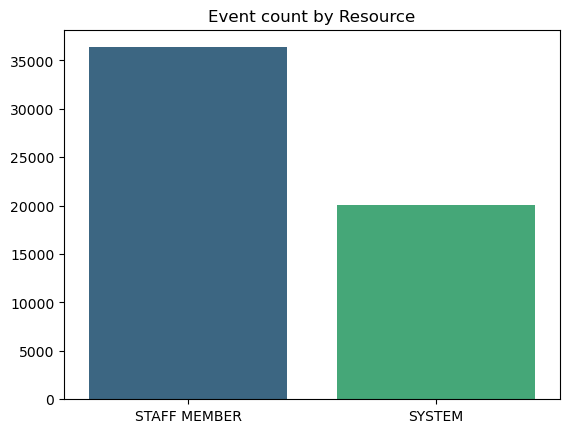

In [103]:
resources = log['org:resource'].unique()
sns.countplot(x='org:resource', data=log, palette='viridis').set(title='Event count by Resource', xlabel='', ylabel='');

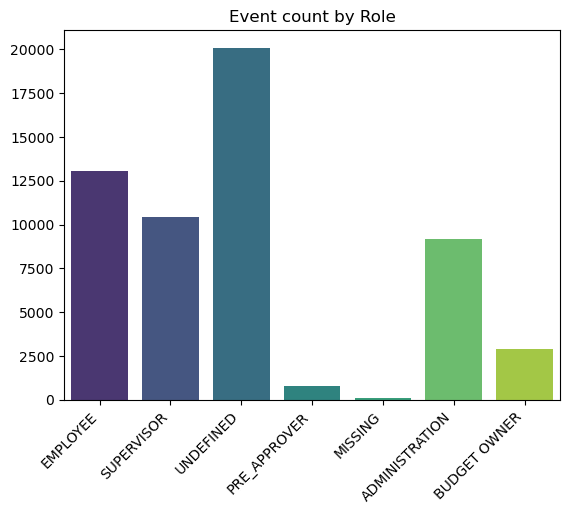

In [104]:
roles = log['org:role'].unique()
sns.countplot(x='org:role', data=log, palette='viridis').set(title='Event count by Role', xlabel='', ylabel='')
plt.xticks(rotation=45, ha='right');

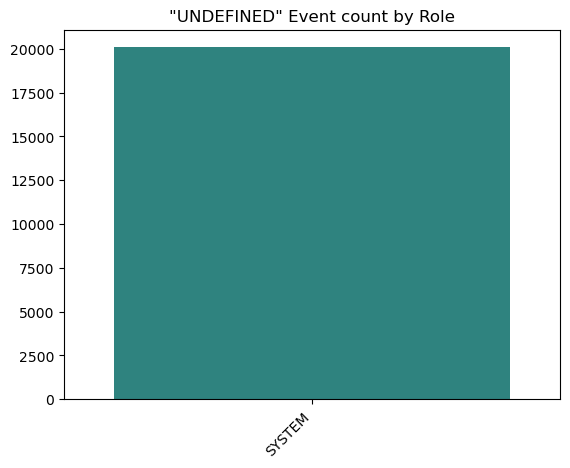

In [105]:
log_i = log[log['org:role'] == 'UNDEFINED']
sns.countplot(x='org:resource', data=log_i, palette='viridis').set(title='"UNDEFINED" Event count by Role', xlabel='', ylabel='')
plt.xticks(rotation=45, ha='right');

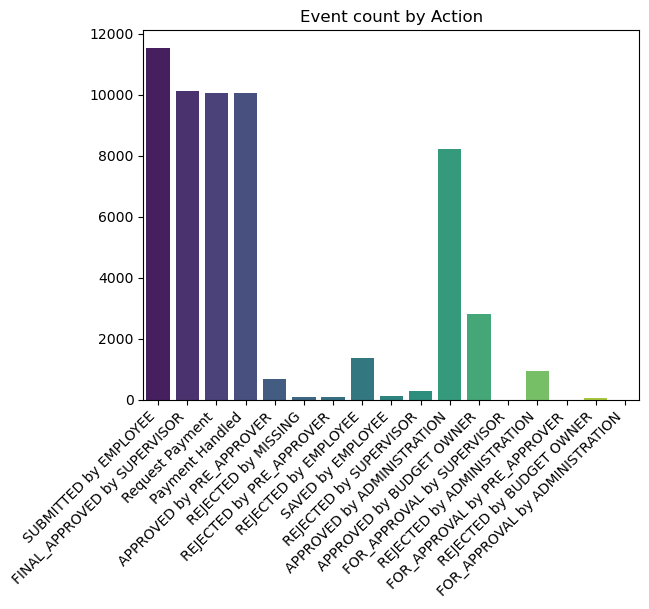

In [106]:
actions = log['concept:name'].unique()
sns.countplot(x='concept:name', data=log, palette='viridis').set(title='Event count by Action', xlabel='', ylabel='')
plt.xticks(rotation=45, ha='right');

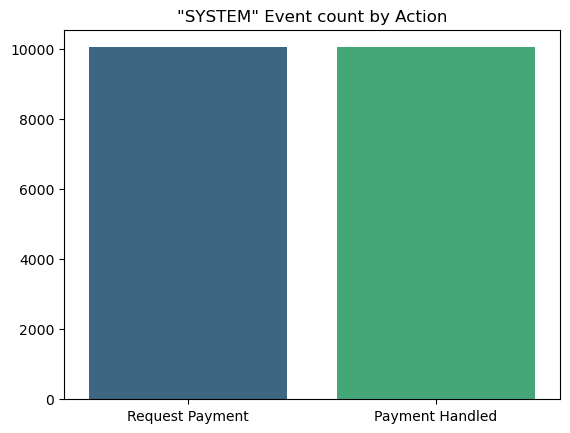

In [107]:
# System Events
log_s = log[log['org:resource'] == 'SYSTEM']
sns.countplot(x='concept:name', data=log_s, palette='viridis').set(title='"SYSTEM" Event count by Action', xlabel='', ylabel='');

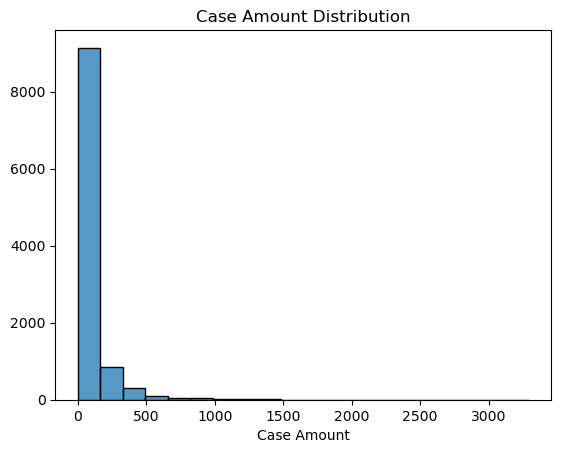

In [108]:
# case amount distribution for distinct case:id
distinct_case_amounts = log.groupby('case:id')['case:Amount'].max()
sns.histplot(distinct_case_amounts, kde=False, bins=20).set(title='Case Amount Distribution', xlabel='Case Amount', ylabel='');

## Process Discovery

Having mined the model we may vizualize it as a Process Tree or Petri Net.

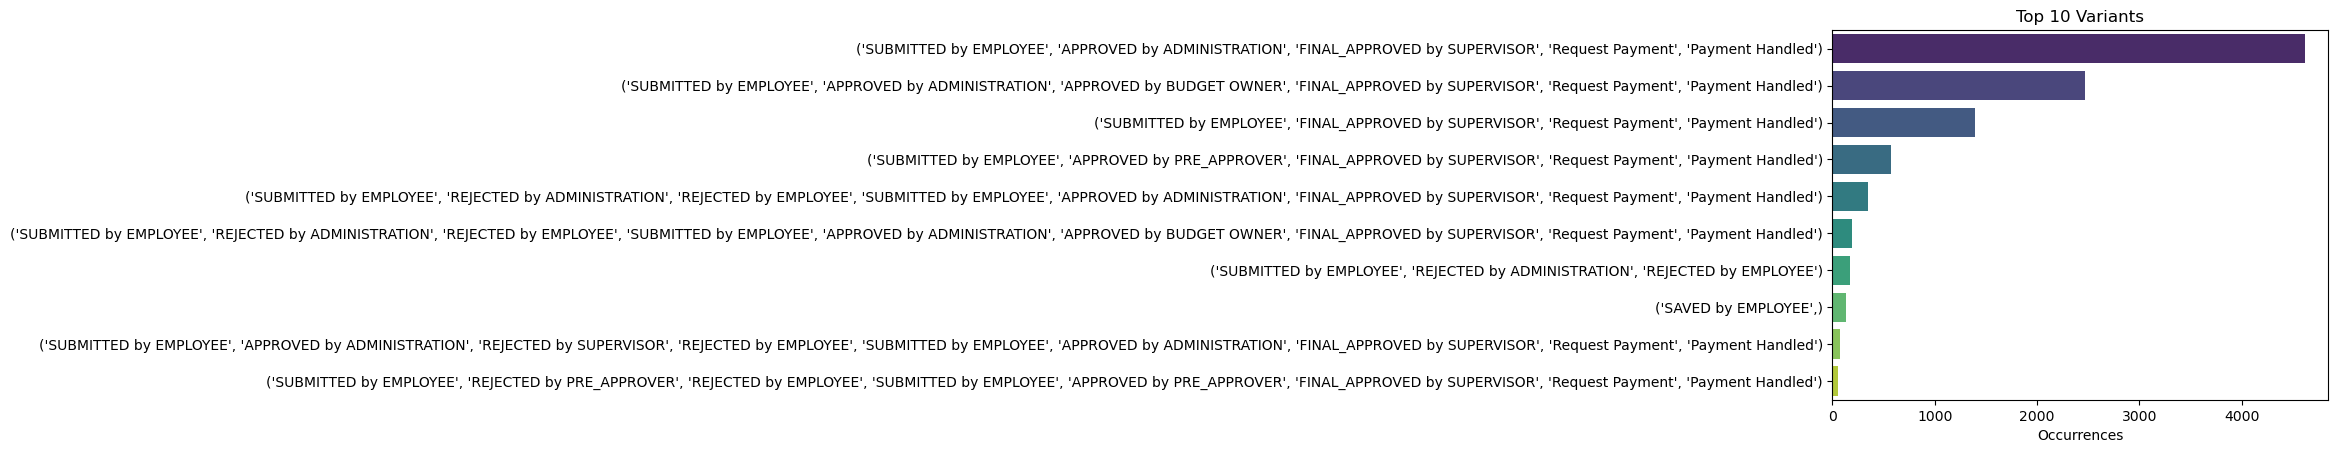

In [109]:
variants_dict = pm4py.get_variants(log)

variants_arr = []
idx = 1
for variant, n in variants_dict.items():
    variant_in_dict = {}
    variant_in_dict['variant_number'] = idx
    variant_in_dict['variant_count'] = n
    variant_in_dict['variant_trace'] = variant
    
    variants_arr.append(variant_in_dict)
    
    idx += 1


variants_df = pd.DataFrame(variants_arr)
variants_df = variants_df.sort_values(by='variant_count', ascending=False)

sns.barplot(x='variant_count', y='variant_trace', data=variants_df[:10], palette='viridis').set(title='Top 10 Variants', xlabel='Occurrences', ylabel='');

In [110]:
cases = log['case:id'].unique()
count_cases_top_10 = variants_df[:10]['variant_count'].sum()
print(f'Top 10 variants account for {count_cases_top_10:,} cases out of {len(cases):,}.')

Top 10 variants account for 10,033 cases out of 10,500.


## Check out BPMN Model

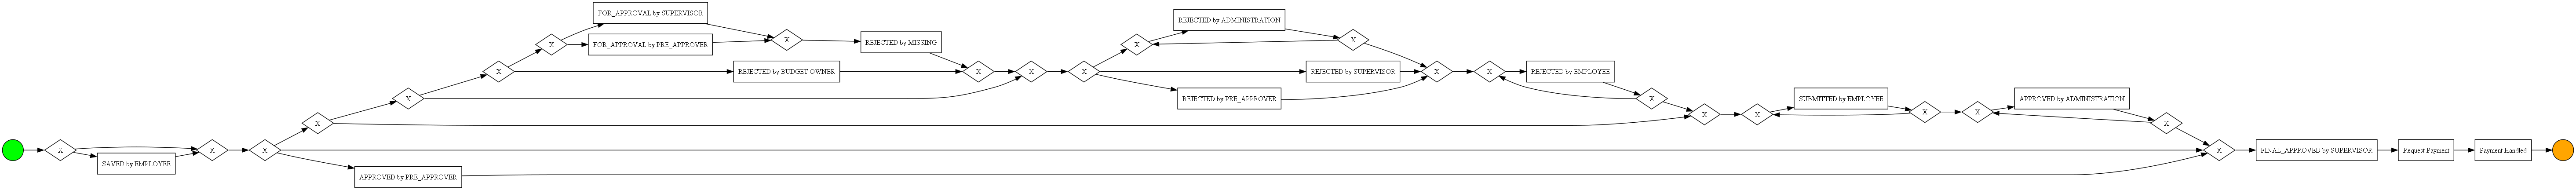

In [111]:
bpmn_model = pm4py.discover_bpmn_inductive(
    log=log,
    noise_threshold=0.8,
    activity_key='concept:name',
    timestamp_key='time:timestamp',
    case_id_key='case:id'
)
pm4py.view_bpmn(bpmn_model)

In BPMN model "x" stands for choice. We may observe that algorithm mined a model with a lot of choices and shortcuts. But on the end of the process it needs to be approved by supervisor. Last two stepps are done by system.

## Process Tree

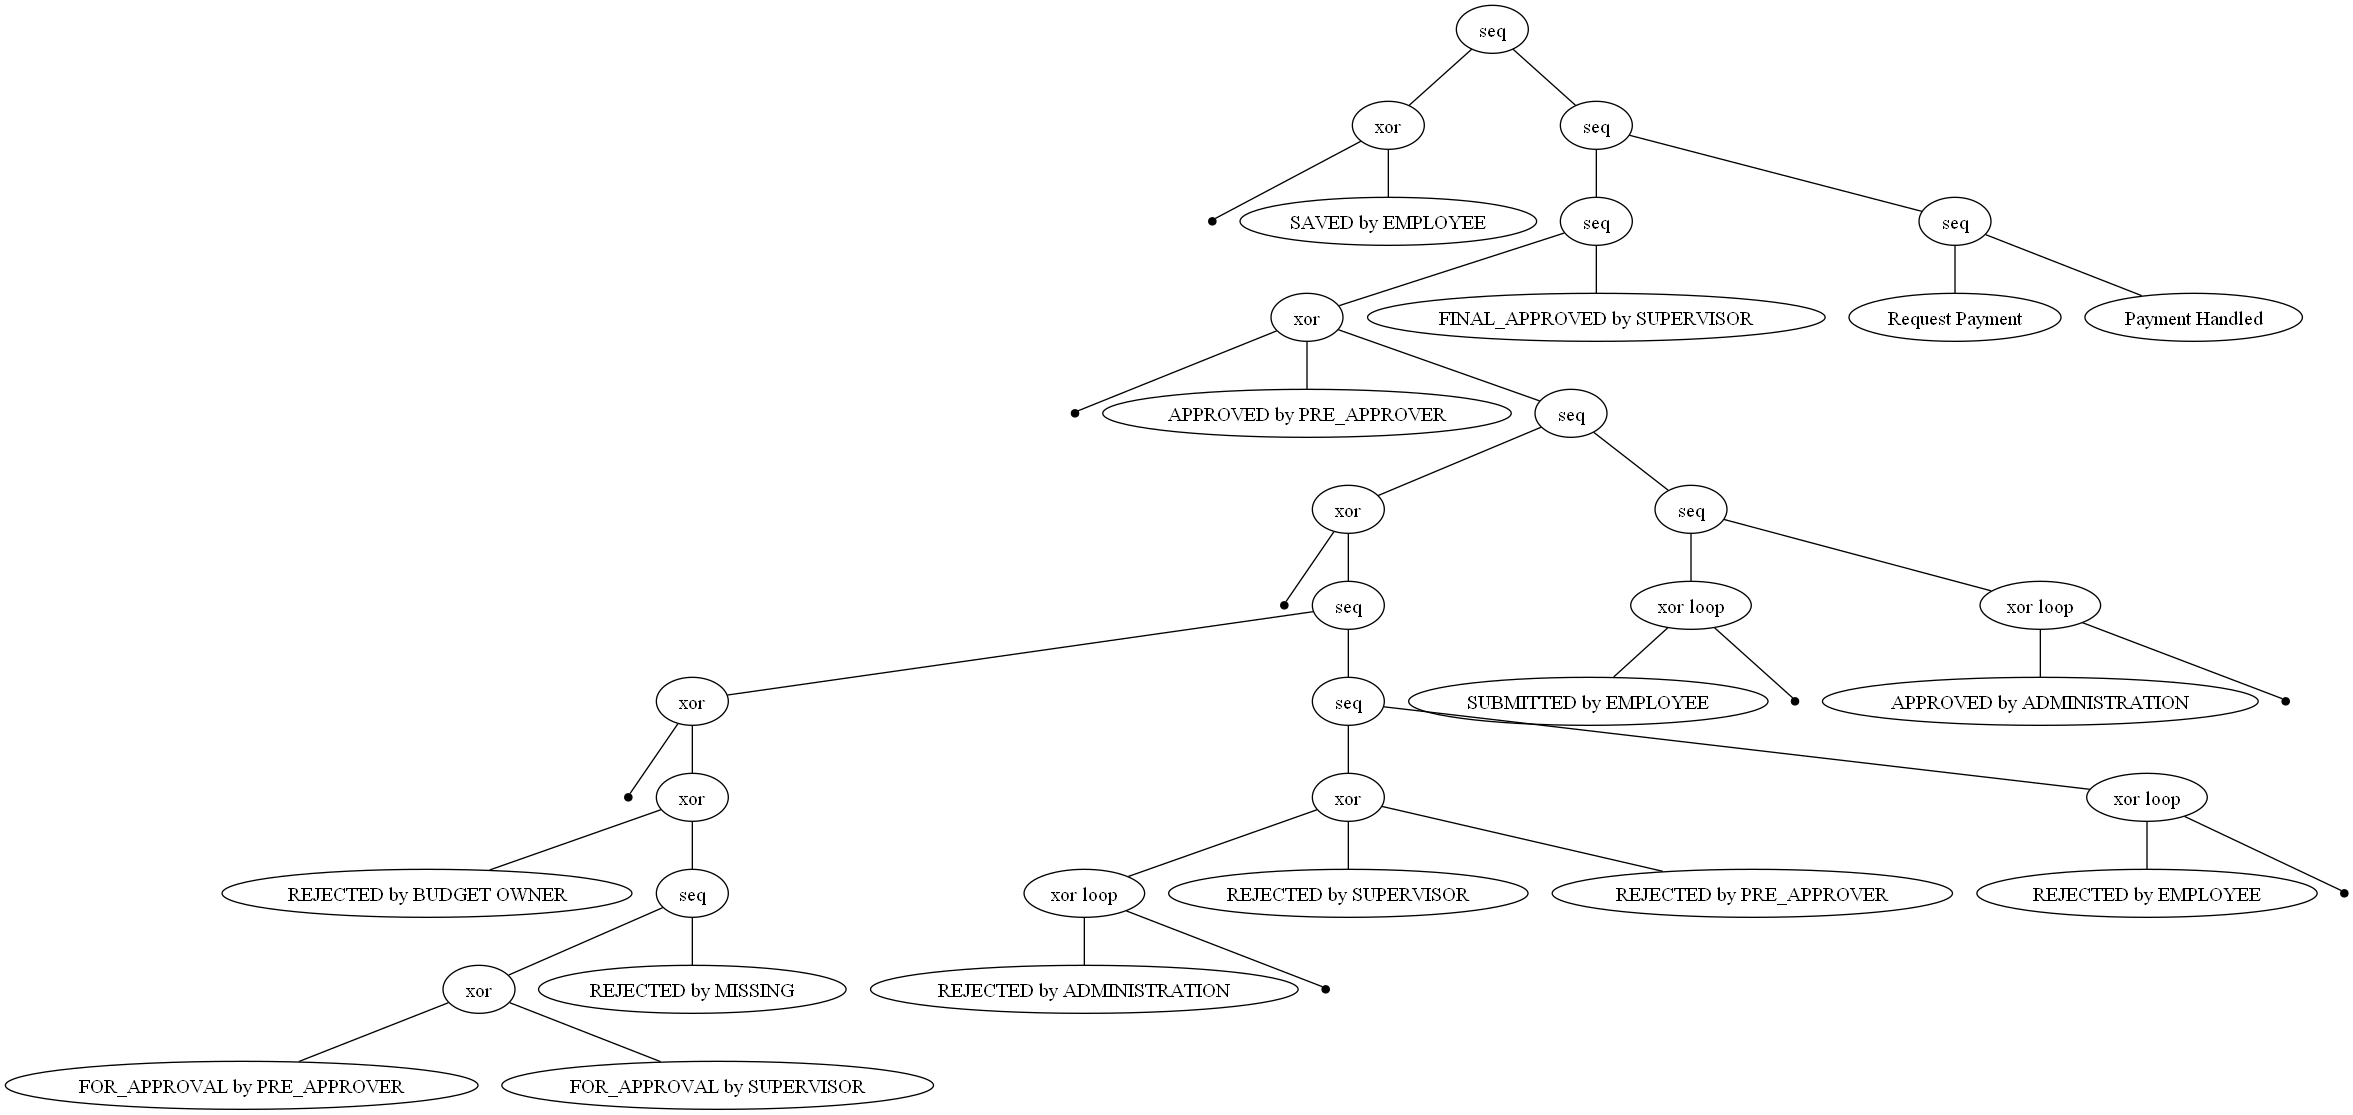

In [112]:
process_tree = pm4py.discover_process_tree_inductive(
    log=log,
    noise_threshold=.8,
    activity_key='concept:name',
    timestamp_key='time:timestamp',
    case_id_key='case:id'
)
pm4py.view_process_tree(process_tree)

## Petri Net

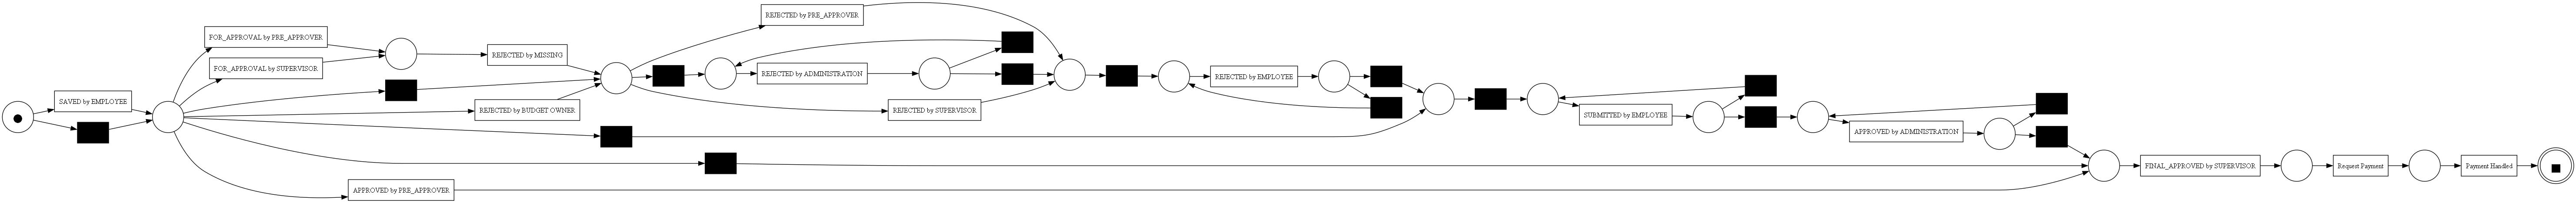

In [113]:
p_net, im, fm = pm4py.discover_petri_net_inductive(
    log=log,
    noise_threshold=.8,
    activity_key='concept:name',
    timestamp_key='time:timestamp',
    case_id_key='case:id'
)
pm4py.view_petri_net(p_net, im, fm)

## Directly-Follows Graph

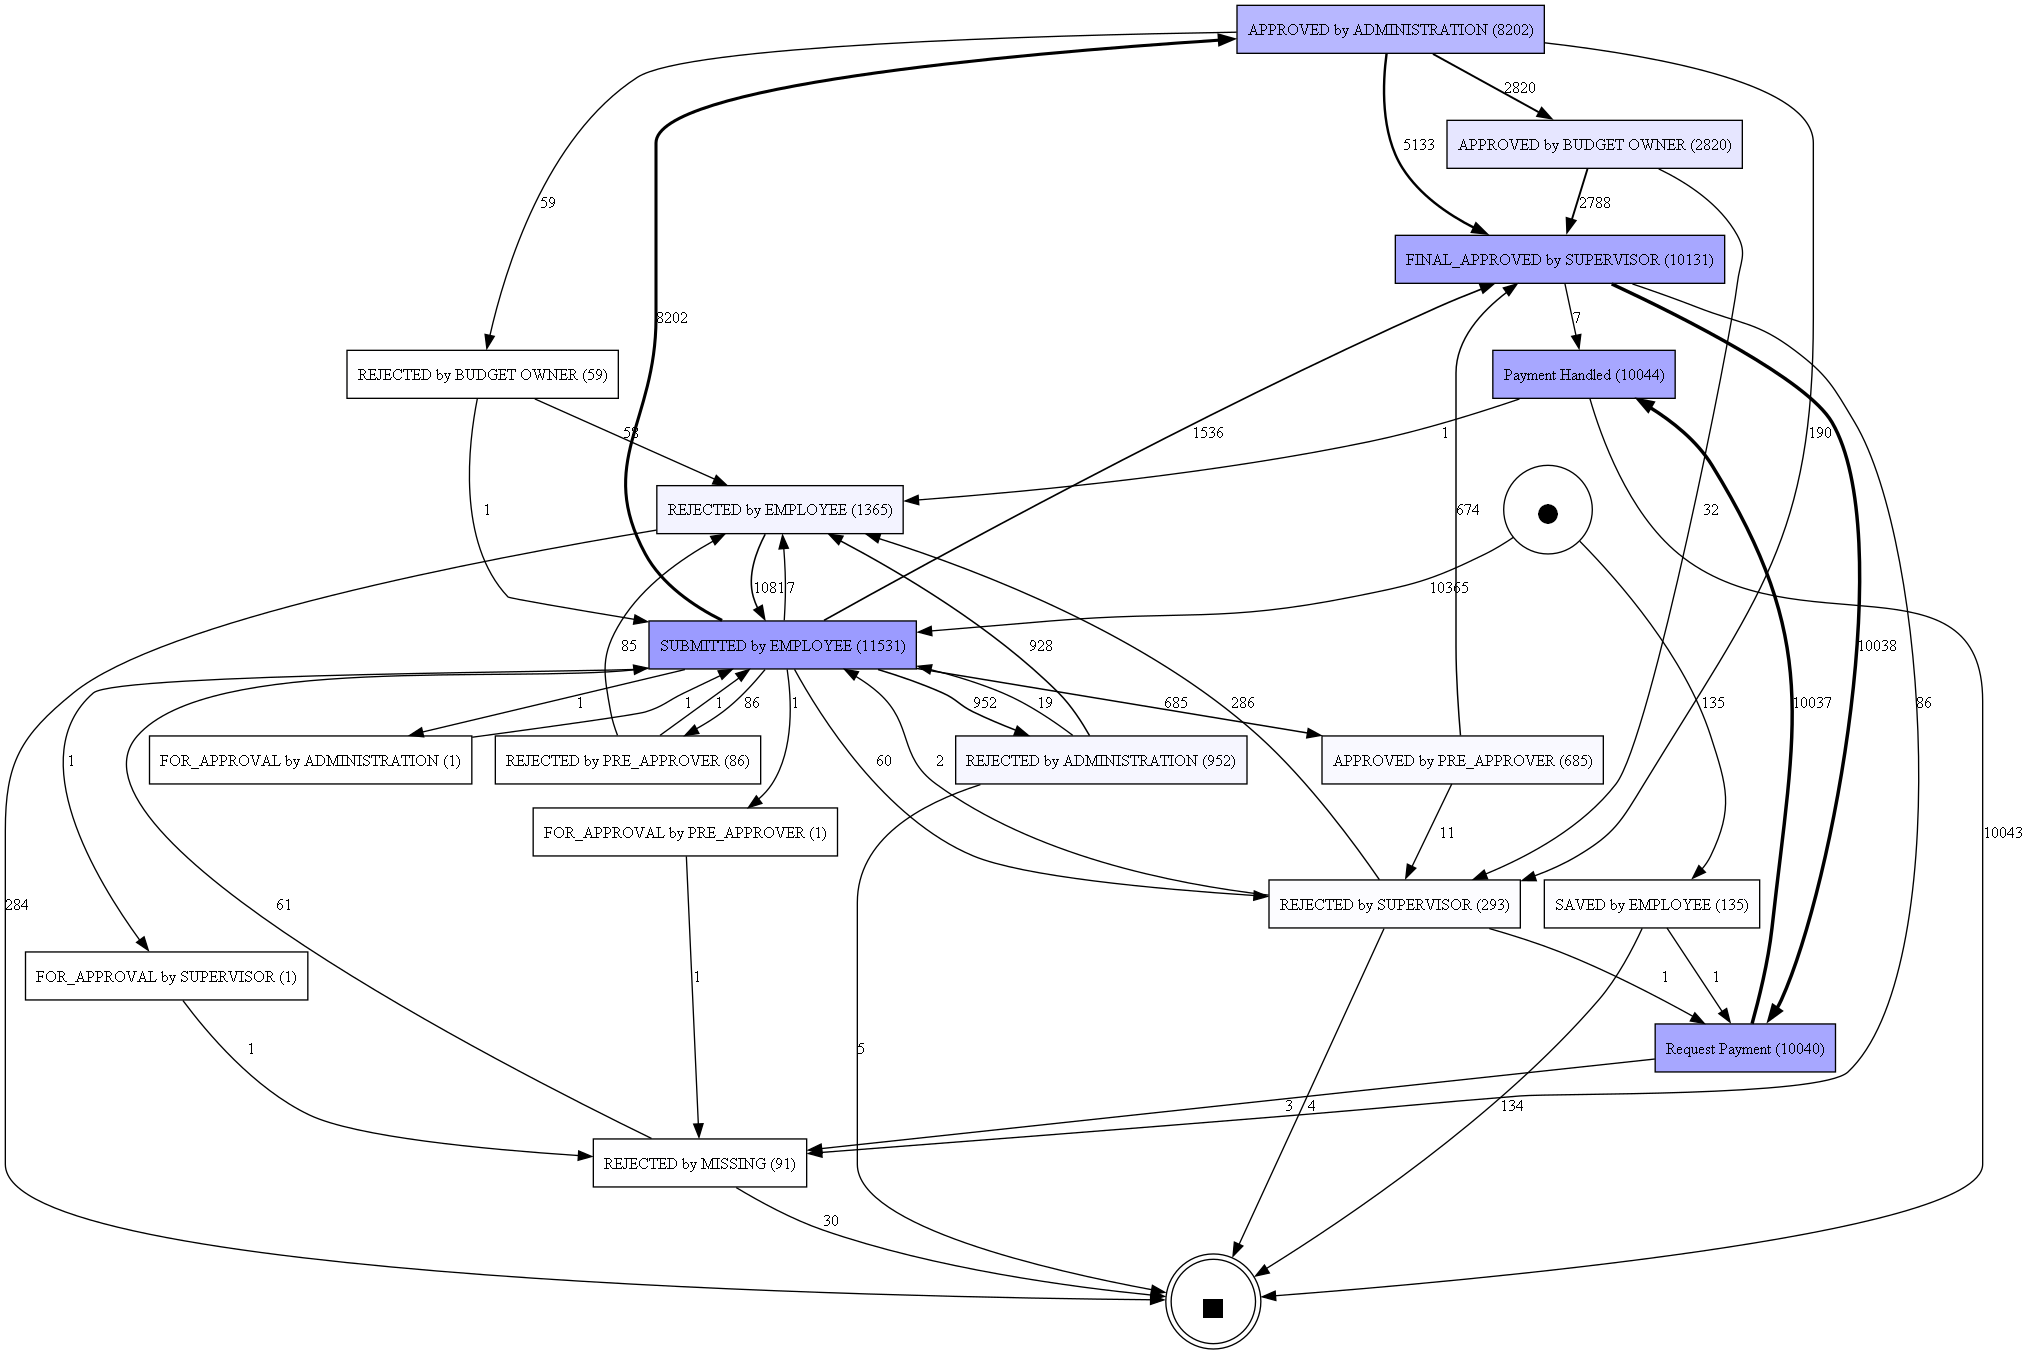

In [114]:
dfg, sa, ea = pm4py.discover_dfg(
    log=log,
    activity_key='concept:name',
    timestamp_key='time:timestamp',
    case_id_key='case:id'
)
pm4py.view_dfg(dfg, sa, ea)

Data Granularity mismatch?

TODO: Try to reshuffle events into new categories and create models again.

## Statistics

TODO

### Process Duration

- How long do the different process instances take? Are there any notable patterns?


Average duration of the whole process

This may take a while, because 'pm4py.get_case_duration' has to calculate the duration of all 10500 traces first


In [169]:
log_c = log['case:concept:name'].unique()
durations = []

for case in log_c:
    durations.append(pm4py.get_case_duration(log, case, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp'))

print(f"The average duration of the domestic process is: {np.array(durations).mean()/3600} hours")


The average duration of the domestic process is: 276.6173275132275 hours


Average duration of each activity

In [211]:
log_f = log[log['case:concept:name'] == 'declaration 86791']
log_d = pd.to_datetime(log_f['time:timestamp'])
print(log_d[1] - log_d[0])


0 days 01:37:58


In [245]:
log = log.sort_values(['case:concept:name', 'time:timestamp'])

log['next_timestamp'] = log.groupby('case:concept:name')['time:timestamp'].shift(-1)  # Calculating the duration of one activity to the next within the same case
log['duration'] = log['next_timestamp'] - log['time:timestamp']

log.drop('next_timestamp', axis=1, inplace=True)  # Drop temporary column

log

,id,org:resource,concept:name,time:timestamp,org:role,case:id,case:concept:name,case:BudgetNumber,case:DeclarationNumber,case:Amount,duration
12788,st_step 100004_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2018-01-30 08:20:07+00:00,EMPLOYEE,declaration 100000,declaration 100000,budget 86566,declaration number 100001,600.844121,8 days 00:38:39
12789,st_step 100003_0,STAFF MEMBER,Declaration APPROVED by ADMINISTRATION,2018-02-07 08:58:46+00:00,ADMINISTRATION,declaration 100000,declaration 100000,budget 86566,declaration number 100001,600.844121,1 days 01:00:19
12790,st_step 100002_0,STAFF MEMBER,Declaration FINAL_APPROVED by SUPERVISOR,2018-02-08 09:59:05+00:00,SUPERVISOR,declaration 100000,declaration 100000,budget 86566,declaration number 100001,600.844121,1 days 01:43:44
12791,dd_declaration 100000_19,SYSTEM,Request Payment,2018-02-09 11:42:49+00:00,UNDEFINED,declaration 100000,declaration 100000,budget 86566,declaration number 100001,600.844121,3 days 04:48:31
12792,dd_declaration 100000_20,SYSTEM,Payment Handled,2018-02-12 16:31:20+00:00,UNDEFINED,declaration 100000,declaration 100000,budget 86566,declaration number 100001,600.844121,NaT
...,...,...,...,...,...,...,...,...,...,...,...
12756,st_step 99997_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2018-01-29 19:58:58+00:00,EMPLOYEE,declaration 99995,declaration 99995,budget 86566,declaration number 99996,26.218933,0 days 00:00:11
12757,st_step 99998_0,STAFF MEMBER,Declaration APPROVED by ADMINISTRATION,2018-01-29 19:59:09+00:00,ADMINISTRATION,declaration 99995,declaration 99995,budget 86566,declaration number 99996,26.218933,0 days 16:59:29
12758,st_step 99999_0,STAFF MEMBER,Declaration FINAL_APPROVED by SUPERVISOR,2018-01-30 12:58:38+00:00,SUPERVISOR,declaration 99995,declaration 99995,budget 86566,declaration number 99996,26.218933,0 days 21:54:27
12759,dd_declaration 99995_19,SYSTEM,Request Payment,2018-01-31 10:53:05+00:00,UNDEFINED,declaration 99995,declaration 99995,budget 86566,declaration number 99996,26.218933,1 days 05:38:12


In [240]:
average_durations = log.groupby('concept:name')['duration'].mean()
average_durations

concept:name
APPROVED by ADMINISTRATION       1 days 21:40:11.115215801
APPROVED by BUDGET OWNER         2 days 21:05:57.758865248
APPROVED by PRE_APPROVER         1 days 21:45:25.626277372
FINAL_APPROVED by SUPERVISOR     3 days 06:48:46.765965847
FOR_APPROVAL by ADMINISTRATION             1 days 00:23:44
FOR_APPROVAL by PRE_APPROVER               4 days 03:10:46
FOR_APPROVAL by SUPERVISOR                 0 days 19:02:47
Payment Handled                            1 days 15:00:24
REJECTED by ADMINISTRATION       2 days 01:07:53.503695881
REJECTED by BUDGET OWNER         2 days 04:51:00.847457627
REJECTED by EMPLOYEE             5 days 04:17:45.522664199
REJECTED by MISSING              8 days 13:26:20.852459016
REJECTED by PRE_APPROVER         1 days 10:05:41.744186046
REJECTED by SUPERVISOR           3 days 16:21:43.110726643
Request Payment                  3 days 13:54:02.706374502
SAVED by EMPLOYEE                         17 days 00:48:01
SUBMITTED by EMPLOYEE            1 days 12:

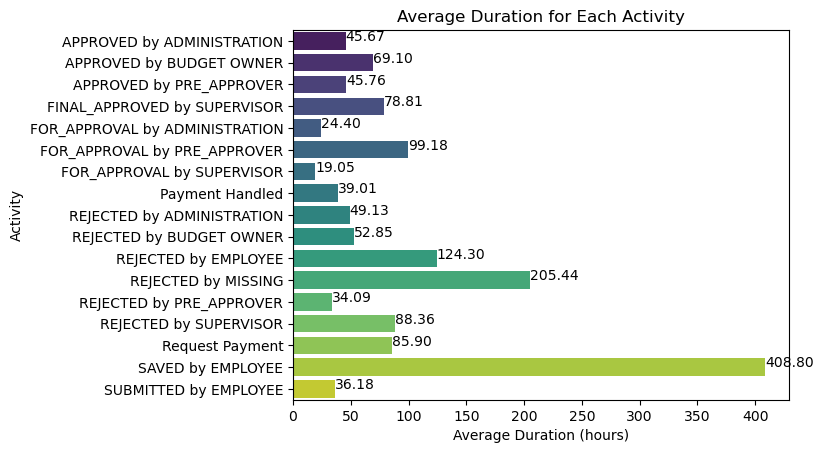

In [251]:

average_durations_hours = average_durations.dt.total_seconds() / 3600  # Converting the average durations to hours


average_durations_hours_clean = average_durations_hours.dropna()  # Removing NaN or infinite values
average_durations_hours_clean = average_durations_hours_clean[average_durations_hours_clean.apply(lambda x: x != float('inf') and x != float('-inf'))]

sns.barplot(x=average_durations_hours_clean.values, y=average_durations_hours_clean.index, palette="viridis")

plt.ylabel('Activity')
plt.xlabel('Average Duration (hours)')
plt.title('Average Duration for Each Activity')


for i, value in enumerate(average_durations_hours_clean.values):  # Displaying the values next to the bars
    plt.text(value, i, f"{value:.2f}")

plt.show()

In [ ]:
case_arr_avg = pm4py.get_case_arrival_average(dataframe, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')

In [ ]:
rework = pm4py.get_rework_cases_per_activity(dataframe, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')

- Are there any bottlenecks? If yes, where? If yes, can you think of any reasons?
    -> Prozessdauer vizualisieren auf Petri Net(?)